In [1]:
import sys; sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os

In [2]:
RAW_DATA_PATH = '../data/raw/cancer_endometri.csv'
PROCESSED_DATA_PATH = '../data/processed/dataset_clustering.csv'
TARGET_COLUMN = 'recidiva_exitus'

SELECTED_COLUMNS = [
    'recidiva_exitus',                  # Target (0=Viva, 1=Mort per recidiva)
    'FIGO2023',                         # Estadiatge (Ordinal 1-14)
    'recep_est_porcent',                # Biomarcador numèric
    'afectacion_linf',                  # Binària (LVSI)
    'grado_histologi',                  # Ordinal (1=Baix, 2=Alt)
    'Reseccion_macroscopica_complet',   # Binària
    'edad',                             # Numèrica
    'imc',                              # Numèrica
    'infiltracion_mi',                  # Infiltració miomètrica (0-3)
    'rece_de_Ppor',                     # Receptor de progesterona (%)
    'fecha_qx',                         # Data cirurgia
    'fecha_de_recidi',                  # Data recidiva
    'Ultima_fecha'                      # Data últim control
]

In [ ]:
df = pd.read_csv(RAW_DATA_PATH)

df = df[SELECTED_COLUMNS]

df = df[df['recidiva_exitus'].notna() & df['recidiva_exitus'].isin([0, 1])]

print(f"✅ Dataset carregat: {df.shape[0]} files, {df.shape[1]} columnes")
print(f"Distribució target ({TARGET_COLUMN}):")
print(df[TARGET_COLUMN].value_counts())

✅ Dataset carregat: 154 files, 13 columnes
Distribució target (recidiva_exitus):
recidiva_exitus
0    120
1     34
Name: count, dtype: int64


In [ ]:
df['fecha_qx'] = pd.to_datetime(df['fecha_qx'], errors='coerce')
df['fecha_de_recidi'] = pd.to_datetime(df['fecha_de_recidi'], errors='coerce')
df['Ultima_fecha'] = pd.to_datetime(df['Ultima_fecha'], errors='coerce')

# Calcular dias_libre_enfermedad
# Si recidiva_exitus=1: punt final és fecha_de_recidi (si existeix) o Ultima_fecha
# Si recidiva_exitus=0: punt final és Ultima_fecha (censura)
df['dias_libre_enfermedad'] = df.apply(
    lambda row: (row['fecha_de_recidi'] - row['fecha_qx']).days 
                if row['recidiva_exitus'] == 1 and pd.notna(row['fecha_de_recidi']) 
                else (row['Ultima_fecha'] - row['fecha_qx']).days 
                if pd.notna(row['Ultima_fecha']) 
                else np.nan,
    axis=1
)

print("✅ Variable 'dias_libre_enfermedad' creada")
print(f"\nEstadístiques:")
print(df['dias_libre_enfermedad'].describe())

# Eliminar columnes de dates (ja no les necessitem)
df = df.drop(columns=['fecha_qx', 'fecha_de_recidi', 'Ultima_fecha'])

✅ Variable 'dias_libre_enfermedad' creada

Estadístiques:
count     144.000000
mean     1044.652778
std       675.216995
min      -338.000000
25%       436.750000
50%       977.500000
75%      1685.750000
max      2481.000000
Name: dias_libre_enfermedad, dtype: float64


C:\Users\gatoj\AppData\Local\Temp\ipykernel_33884\273246574.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['fecha_qx'] = pd.to_datetime(df['fecha_qx'], errors='coerce')
C:\Users\gatoj\AppData\Local\Temp\ipykernel_33884\273246574.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['fecha_de_recidi'] = pd.to_datetime(df['fecha_de_recidi'], errors='coerce')


📊 ANÀLISI DE VALORS NULS (NANs)

🔴 Columnes amb valors nuls:

                                Nuls  Percentatge    Tipus
Reseccion_macroscopica_complet   127        82.47  float64
rece_de_Ppor                      69        44.81  float64
recep_est_porcent                 67        43.51  float64
FIGO2023                          18        11.69  float64
afectacion_linf                   16        10.39  float64
grado_histologi                   15         9.74  float64
infiltracion_mi                   13         8.44  float64
dias_libre_enfermedad             10         6.49  float64
imc                                6         3.90  float64

📈 Total files: 154
📉 Total nuls en tot el dataset: 341


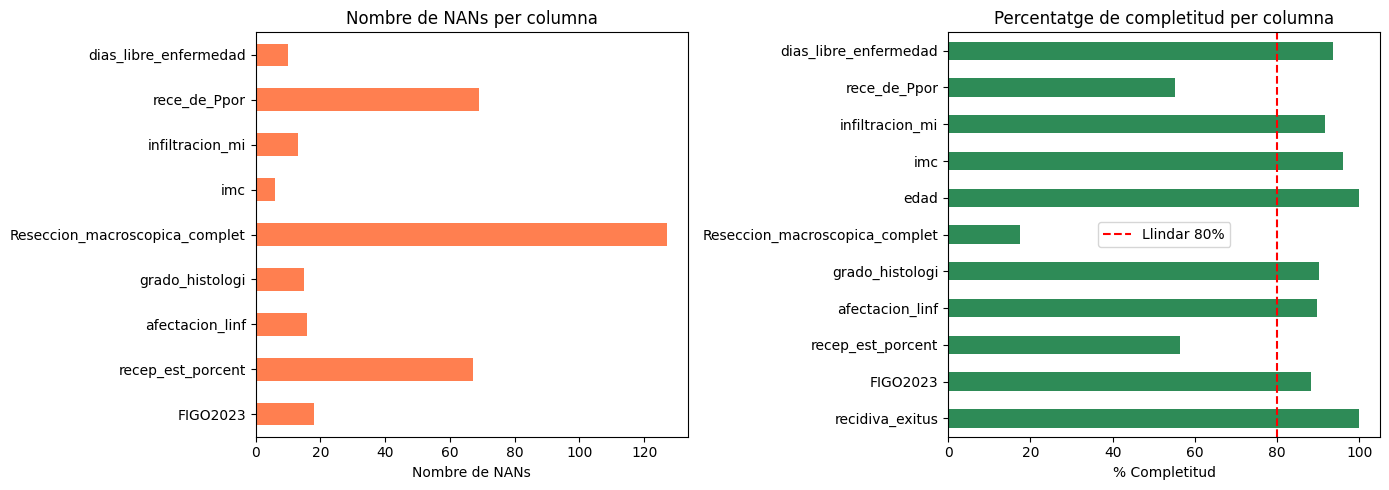

In [5]:
# Anàlisi complet de valors nuls
print("=" * 60)
print("📊 ANÀLISI DE VALORS NULS (NANs)")
print("=" * 60)

# Resum de nuls per columna
nan_summary = pd.DataFrame({
    'Nuls': df.isnull().sum(),
    'Percentatge': (df.isnull().sum() / len(df) * 100).round(2),
    'Tipus': df.dtypes
})
nan_summary = nan_summary[nan_summary['Nuls'] > 0].sort_values('Nuls', ascending=False)

if len(nan_summary) > 0:
    print("\n🔴 Columnes amb valors nuls:\n")
    print(nan_summary)
else:
    print("\n✅ No hi ha valors nuls!")

print(f"\n📈 Total files: {len(df)}")
print(f"📉 Total nuls en tot el dataset: {df.isnull().sum().sum()}")

# Visualització
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gràfic 1: Barres de nuls per columna
ax1 = axes[0]
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0]
if len(null_counts) > 0:
    null_counts.plot(kind='barh', ax=ax1, color='coral')
    ax1.set_title('Nombre de NANs per columna')
    ax1.set_xlabel('Nombre de NANs')
else:
    ax1.text(0.5, 0.5, 'No hi ha NANs!', ha='center', va='center', fontsize=14)
    ax1.set_title('Nombre de NANs per columna')

# Gràfic 2: Heatmap de completitud
ax2 = axes[1]
completeness = (1 - df.isnull().mean()) * 100
completeness.plot(kind='barh', ax=ax2, color='seagreen')
ax2.set_title('Percentatge de completitud per columna')
ax2.set_xlabel('% Completitud')
ax2.axvline(x=80, color='red', linestyle='--', label='Llindar 80%')
ax2.legend()

plt.tight_layout()
plt.show()

In [6]:
# Convertir totes les columnes a numèric
numeric_cols = ['recep_est_porcent', 'edad', 'imc', 'grado_histologi',
                'afectacion_linf', 'Reseccion_macroscopica_complet', 'FIGO2023',
                'infiltracion_mi', 'rece_de_Ppor', 'dias_libre_enfermedad']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("✅ Columnes convertides a numèric")
print("\nNuls després de conversió:")
print(df.isnull().sum())

✅ Columnes convertides a numèric

Nuls després de conversió:
recidiva_exitus                     0
FIGO2023                           18
recep_est_porcent                  67
afectacion_linf                    16
grado_histologi                    15
Reseccion_macroscopica_complet    127
edad                                0
imc                                 6
infiltracion_mi                    13
rece_de_Ppor                       69
dias_libre_enfermedad              10
dtype: int64


In [7]:
print("=" * 60)
print("🔧 IMPUTACIÓ DE VALORS NULS")
print("=" * 60)

imputations_log = []

# 1. Variables contínues → MITJANA
continuous_cols = ['recep_est_porcent', 'edad', 'rece_de_Ppor', 'dias_libre_enfermedad']
for col in continuous_cols:
    if col in df.columns and df[col].isna().sum() > 0:
        mean_val = df[col].mean()
        n_nulls = df[col].isna().sum()
        df[col] = df[col].fillna(mean_val)
        imputations_log.append({'Columna': col, 'Mètode': 'Mitjana', 'Valor': round(mean_val, 2), 'Imputats': n_nulls})
        print(f"✓ {col}: imputat {n_nulls} valors amb MITJANA = {mean_val:.2f}")

# 2. IMC → MEDIANA (robusta a outliers)
if 'imc' in df.columns and df['imc'].isna().sum() > 0:
    median_val = df['imc'].median()
    n_nulls = df['imc'].isna().sum()
    df['imc'] = df['imc'].fillna(median_val)
    imputations_log.append({'Columna': 'imc', 'Mètode': 'Mediana', 'Valor': round(median_val, 2), 'Imputats': n_nulls})
    print(f"✓ imc: imputat {n_nulls} valors amb MEDIANA = {median_val:.2f}")

# 3. Variables ordinals/binàries → MODA
ordinal_cols = ['FIGO2023', 'afectacion_linf', 'grado_histologi', 
                'Reseccion_macroscopica_complet', 'infiltracion_mi']
for col in ordinal_cols:
    if col in df.columns and df[col].isna().sum() > 0:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 0
        n_nulls = df[col].isna().sum()
        df[col] = df[col].fillna(mode_val)
        imputations_log.append({'Columna': col, 'Mètode': 'Moda', 'Valor': int(mode_val), 'Imputats': n_nulls})
        print(f"✓ {col}: imputat {n_nulls} valors amb MODA = {mode_val}")

# Resum d'imputacions
print("\n" + "=" * 60)
print("📋 RESUM D'IMPUTACIONS")
print("=" * 60)
if imputations_log:
    imp_df = pd.DataFrame(imputations_log)
    print(imp_df.to_string(index=False))
else:
    print("No s'han fet imputacions (no hi havia nuls)")

# Verificació final
print(f"\n✅ Nuls restants: {df.isnull().sum().sum()}")
print(f"📊 Shape final: {df.shape}")

🔧 IMPUTACIÓ DE VALORS NULS
✓ recep_est_porcent: imputat 67 valors amb MITJANA = 76.28
✓ rece_de_Ppor: imputat 69 valors amb MITJANA = 69.33
✓ dias_libre_enfermedad: imputat 10 valors amb MITJANA = 1044.65
✓ imc: imputat 6 valors amb MEDIANA = 29.40
✓ FIGO2023: imputat 18 valors amb MODA = 1.0
✓ afectacion_linf: imputat 16 valors amb MODA = 0.0
✓ grado_histologi: imputat 15 valors amb MODA = 1.0
✓ Reseccion_macroscopica_complet: imputat 127 valors amb MODA = 0.0
✓ infiltracion_mi: imputat 13 valors amb MODA = 1.0

📋 RESUM D'IMPUTACIONS
                       Columna  Mètode   Valor  Imputats
             recep_est_porcent Mitjana   76.28        67
                  rece_de_Ppor Mitjana   69.33        69
         dias_libre_enfermedad Mitjana 1044.65        10
                           imc Mediana   29.40         6
                      FIGO2023    Moda    1.00        18
               afectacion_linf    Moda    0.00        16
               grado_histologi    Moda    1.00        15
Res

In [8]:
# Guardar dataset net
os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)
df.to_csv(PROCESSED_DATA_PATH, index=False)

print(f"✅ Dataset guardat a: {PROCESSED_DATA_PATH}")
print(f"📊 Dimensions finals: {df.shape}")
print(f"\nColumnes: {list(df.columns)}")
print(f"\nPrimeres files:")
df.head()

✅ Dataset guardat a: ../data/processed/dataset_clustering.csv
📊 Dimensions finals: (154, 11)

Columnes: ['recidiva_exitus', 'FIGO2023', 'recep_est_porcent', 'afectacion_linf', 'grado_histologi', 'Reseccion_macroscopica_complet', 'edad', 'imc', 'infiltracion_mi', 'rece_de_Ppor', 'dias_libre_enfermedad']

Primeres files:


,recidiva_exitus,FIGO2023,recep_est_porcent,afectacion_linf,grado_histologi,Reseccion_macroscopica_complet,edad,imc,infiltracion_mi,rece_de_Ppor,dias_libre_enfermedad
0,0,14.0,80.000000,0.0,2.0,0.0,68.0,39.40,1.0,10.000000,613.000000
1,0,1.0,76.275862,0.0,1.0,0.0,92.0,24.14,1.0,69.329412,1044.652778
2,0,1.0,76.275862,1.0,1.0,0.0,72.0,38.80,1.0,69.329412,1709.000000
3,1,11.0,90.000000,1.0,1.0,0.0,78.0,36.30,2.0,90.000000,979.000000
4,0,1.0,90.000000,0.0,1.0,0.0,68.0,31.10,1.0,90.000000,1889.000000


In [9]:
# Separem features del target
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Normalitzar les features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Features normalitzades: {X_scaled.shape}")
print(f"Columnes: {list(X.columns)}")

✅ Features normalitzades: (154, 10)
Columnes: ['FIGO2023', 'recep_est_porcent', 'afectacion_linf', 'grado_histologi', 'Reseccion_macroscopica_complet', 'edad', 'imc', 'infiltracion_mi', 'rece_de_Ppor', 'dias_libre_enfermedad']


C:\Users\gatoj\AppData\Local\Temp\ipykernel_33884\3621693255.py:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gatoj\AppData\Local\Temp\ipykernel_33884\3621693255.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\gatoj\OneDrive\Escritorio\Hackathon\bitsXlamarato-2025-pau_overfitting\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\gatoj\OneDrive\Escritorio\Hackathon\bitsXlamarato-2025-pau_overfitting\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


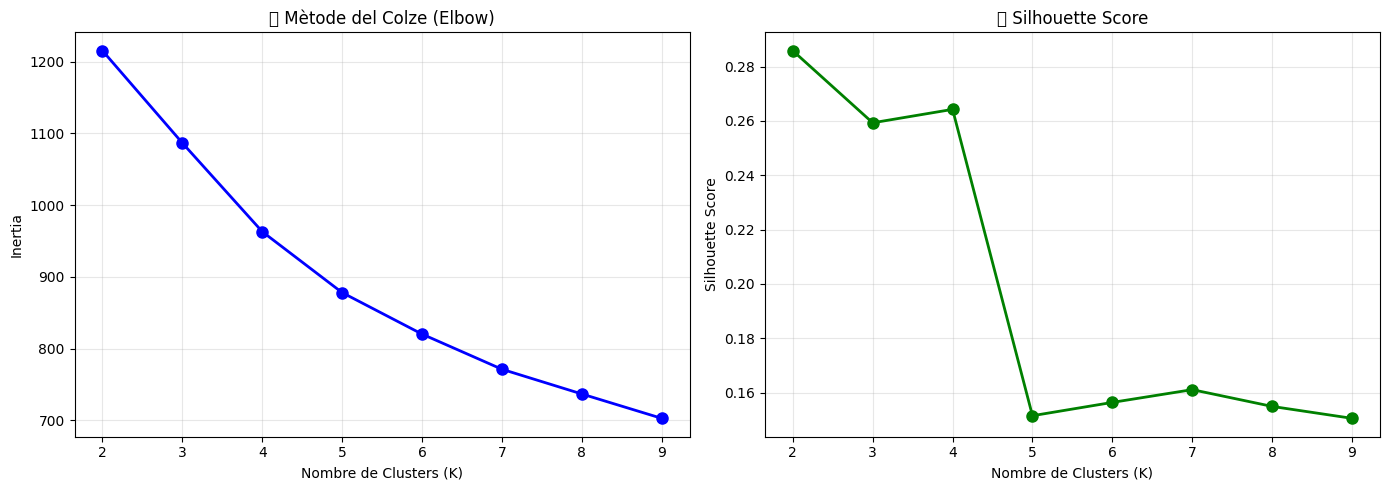


🎯 Millor K segons Silhouette: 2 (score: 0.286)


In [10]:
# Mètode del colze i Silhouette
K_range = range(2, 10)
inertias = []
silhouettes = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualització
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Nombre de Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('🔍 Mètode del Colze (Elbow)')
axes[0].grid(True, alpha=0.3)

# Silhouette
axes[1].plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Nombre de Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('📊 Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Millor K segons Silhouette
best_k = K_range[np.argmax(silhouettes)]
print(f"\n🎯 Millor K segons Silhouette: {best_k} (score: {max(silhouettes):.3f})")

In [11]:
# Usar K trobat o definir manualment
K_OPTIMAL = 3  # Canvia si vols un altre K

kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"✅ Clustering completat amb K={K_OPTIMAL}")
print(f"\nDistribució de clusters:")
print(df['cluster'].value_counts().sort_index())

✅ Clustering completat amb K=3

Distribució de clusters:
cluster
0     38
1    100
2     16
Name: count, dtype: int64


In [12]:
# Perfil de cada cluster
print("=" * 60)
print("📊 PERFIL DELS CLUSTERS")
print("=" * 60)

cluster_profile = df.groupby('cluster').agg({
    'recidiva_exitus': ['mean', 'sum', 'count'],
    'edad': 'mean',
    'FIGO2023': 'mean',
    'recep_est_porcent': 'mean',
    'grado_histologi': 'mean',
    'infiltracion_mi': 'mean',
    'afectacion_linf': 'mean',
    'imc': 'mean'
}).round(2)

print(cluster_profile)

# Resum simplificat
print("\n" + "=" * 60)
print("🎯 RESUM PER CLUSTER")
print("=" * 60)
for c in sorted(df['cluster'].unique()):
    subset = df[df['cluster'] == c]
    n = len(subset)
    exitus = subset['recidiva_exitus'].sum()
    pct_exitus = (exitus / n * 100)
    edad_mean = subset['edad'].mean()
    print(f"\nCluster {c}: {n} pacients ({pct_exitus:.1f}% exitus)")
    print(f"  - Edat mitjana: {edad_mean:.1f} anys")
    print(f"  - FIGO mitjà: {subset['FIGO2023'].mean():.1f}")
    print(f"  - Receptor estrogen: {subset['recep_est_porcent'].mean():.1f}%")

📊 PERFIL DELS CLUSTERS
        recidiva_exitus             edad FIGO2023 recep_est_porcent  \
                   mean sum count   mean     mean              mean   
cluster                                                               
0                  0.71  27    38  63.61     8.18             71.16   
1                  0.06   6   100  61.50     1.73             82.81   
2                  0.06   1    16  61.25     2.44             47.58   

        grado_histologi infiltracion_mi afectacion_linf    imc  
                   mean            mean            mean   mean  
cluster                                                         
0                  1.58            1.87            0.63  27.22  
1                  1.02            0.84            0.03  31.98  
2                  1.25            0.88            0.06  29.88  

🎯 RESUM PER CLUSTER

Cluster 0: 38 pacients (71.1% exitus)
  - Edat mitjana: 63.6 anys
  - FIGO mitjà: 8.2
  - Receptor estrogen: 71.2%

Cluster 1: 100 pacient

C:\Users\gatoj\AppData\Local\Temp\ipykernel_33884\1970801613.py:21: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\gatoj\OneDrive\Escritorio\Hackathon\bitsXlamarato-2025-pau_overfitting\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


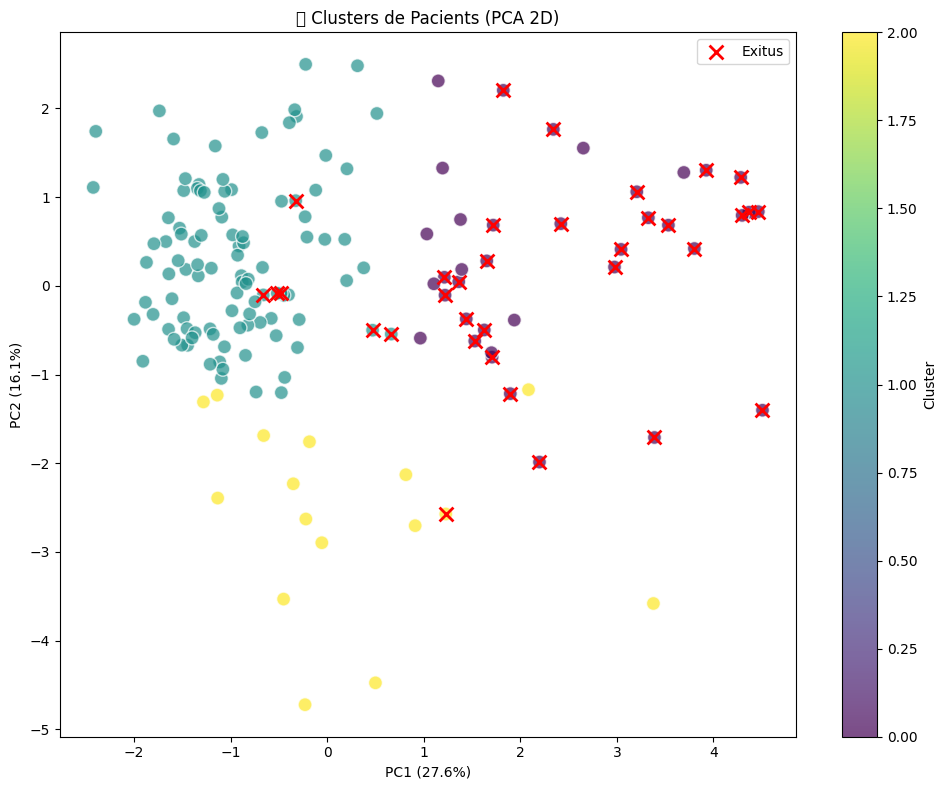

In [13]:
from sklearn.decomposition import PCA

# PCA per visualització 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                      c=df['cluster'], cmap='viridis', 
                      s=100, alpha=0.7, edgecolors='white')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('🔬 Clusters de Pacients (PCA 2D)')

# Marcar exitus
exitus_mask = df['recidiva_exitus'] == 1
plt.scatter(X_pca[exitus_mask, 0], X_pca[exitus_mask, 1], 
            c='red', marker='x', s=100, linewidths=2, label='Exitus')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Guardar dataset amb clusters
os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)
df.to_csv(PROCESSED_DATA_PATH, index=False)

print(f"✅ Dataset guardat a: {PROCESSED_DATA_PATH}")
print(f"📊 Dimensions finals: {df.shape}")
print(f"Columnes: {list(df.columns)}")

✅ Dataset guardat a: ../data/processed/dataset_clustering.csv
📊 Dimensions finals: (154, 12)
Columnes: ['recidiva_exitus', 'FIGO2023', 'recep_est_porcent', 'afectacion_linf', 'grado_histologi', 'Reseccion_macroscopica_complet', 'edad', 'imc', 'infiltracion_mi', 'rece_de_Ppor', 'dias_libre_enfermedad', 'cluster']
